In [3]:
import osmnx as ox
import random
from shapely.geometry import Point
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random

#bb coordinates
north, south, east, west = 29.7700, 29.7500, -95.3500, -95.4000
# Download graph
G_small = ox.graph_from_bbox(north, south, east, west, network_type='drive')

#making danger scores
for u, v, data in G_small.edges(data=True):
    data['danger'] = data.get('danger', random.randint(1, 10)) 
    
# Define classes
class Hospital: 
    def __init__(self, location, capacity):
        self.location = location  # Nearest node in the road network
        self.capacity = capacity  # Maximum number of victims it can handle at once

class Victim: 
    def __init__(self, location, rating): 
        self.location = location  # Nearest node in the road network
        self.rating = rating      # 'R' for red (critical), 'G' for green (less critical), 'U' for unknown
        self.visited = False      # Track if a victim has already been visited

class Vehicle:
    def __init__(self, location, type, max_risk, capacity, current_amt, index):
        self.type = type           # Type of vehicle: ambulance, helicopter, etc.
        self.max_risk = max_risk  # Max risk level the vehicle can handle
        self.location = location  # Nearest node in the road network
        self.capacity = capacity  # How many people (green) victims known at once
        self.current_amt = current_amt  # How many people are currently in it
        self.route = []
        self.risk_scores = []
        self.index = index

# Bounding box coordinates (the area you are working with)
north, south, east, west = 29.7700, 29.7500, -95.3500, -95.4000

# Load the road network for the bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Function to find the nearest node in the graph for a given location
def get_nearest_node(location):
    # Create a point geometry from the (latitude, longitude) location
    point = Point(location[1], location[0])  # OSMnx uses (longitude, latitude)
    nearest_node = ox.distance.nearest_nodes(G, X=point.x, Y=point.y)
    return nearest_node

# Generate 2 random hospitals, 5 victims, and 2 vehicles
hospitals = []
victims = []
vehicles = []

# Randomly generate 2 hospitals with random locations and capacities
for _ in range(3):
    lat = random.uniform(south, north)
    lon = random.uniform(west, east)
    capacity = random.randint(10, 50)  # Random capacity
    nearest_node = get_nearest_node((lat, lon))  # Get the nearest node in the road network
    hospitals.append(Hospital(location=nearest_node, capacity=capacity))

# Randomly generate 5 victims with random locations and ratings
ratings = ['R', 'G', 'U']  # Red, Green, Unknown
for _ in range(15):
    lat = random.uniform(south, north)
    lon = random.uniform(west, east)
    rating = random.choice(ratings)
    nearest_node = get_nearest_node((lat, lon))  # Get the nearest node in the road network
    victims.append(Victim(location=nearest_node, rating=rating))

# Randomly generate 2 vehicles with random locations, max_risk, and capacity
vehicle_types = ['ambulance', 'helicopter', 'rescue_truck']
idx = 1  # Initialize index for vehicles
for _ in range(2):
    lat = random.uniform(south, north)
    lon = random.uniform(west, east)   
    vehicle_type = random.choice(vehicle_types)
    
    # Set max_risk based on vehicle type
    if vehicle_type == 'ambulance':
        max_risk = 5  # Ambulance has max risk of 5
    elif vehicle_type == 'rescue_truck':
        max_risk = 7  # Rescue truck has max risk of 7
    else:
        max_risk = 10  # Helicopter has max risk of 10
    
    capacity = random.randint(1, 4)  # Random capacity for the vehicle
    current_amt = 0  # Start with no victims in the vehicle
    hospital = random.choice(hospitals)  # Assign the starting location to a random hospital
    nearest_node = hospital.location  # It must begin at a hospital
    
    # Create a vehicle and append it to the list
    vehicles.append(
        Vehicle(location=nearest_node, type=vehicle_type, max_risk=max_risk, capacity=capacity, current_amt=current_amt, index=idx)
    )
    
    idx += 1  # Increment the index for the next vehicle


# Output the information about the hospitals, victims, and vehicles
print("Hospitals:")
for hospital in hospitals:
    print(f"Location (Node): {hospital.location}, Capacity: {hospital.capacity}")

print("\nVictims:")
for victim in victims:
    print(f"Location (Node): {victim.location}, Rating: {victim.rating}, Visited: {victim.visited}")

print("\nVehicles:")
for vehicle in vehicles:
    print(f"Type: {vehicle.type}, Location (Node): {vehicle.location}, Max Risk: {vehicle.max_risk}, "
          f"Capacity: {vehicle.capacity}, Current Amount: {vehicle.current_amt}")

import osmnx as ox
import networkx as nx
import random
alpha =1 
beta = 0.2
# Modify the vehicle_risk function to return time and risk as well
def vehicle_risk(u, v, data, vehicle_type, vehicle_max_risk=5, alpha=1, beta=0.5):
    # Define different risk thresholds for different vehicles
    if vehicle_type == 'ambulance':
        vehicle_max_risk = 5
        speed = 15  # m/s
    elif vehicle_type == 'helicopter':
        vehicle_max_risk = 10  # Helicopters can avoid some dangers (e.g., traffic)
        speed = 70  # m/s
    elif vehicle_type == 'rescue_truck':
        vehicle_max_risk = 7  # Rescue trucks may be slower but more robust
        speed = 10  # m/s (

    # Get distance (length of the edge) in meters
    distance = data.get('length', 1)  # Default to 1 if no length is available
    time = distance / speed
    
    # Get danger
    temp_danger = data.get('danger', 0)
    
    # If the risk (danger) is above the threshold, make the edge inaccessible
    if temp_danger > vehicle_max_risk:
        return float('inf'), 0, 0  # Inaccessible if danger is too high (time=0, risk=0) - 1:09 pm (maybe change this to inf) 
    
    # combined weight/score as a linear combination of time and danger
    combined_weight = alpha * time + beta * temp_danger
    return combined_weight, time, temp_danger  # Return time and danger in addition to the combined weight

# Apply the modified vehicle_risk function to set edge weights and store time and risk values
for u, v, data in G_small.edges(data=True):
    data['weight_ambulance'], data['time_ambulance'], data['risk_ambulance'] = vehicle_risk(u, v, data, 'ambulance')
    data['weight_helicopter'], data['time_helicopter'], data['risk_helicopter'] = vehicle_risk(u, v, data, 'helicopter')
    data['weight_rescue_truck'], data['time_rescue_truck'], data['risk_rescue_truck'] = vehicle_risk(u, v, data, 'rescue_truck')

# Create the matrices (dictionary of dictionaries) for each vehicle type
vehicle_matrices = {'ambulance': {}, 'helicopter': {}, 'rescue_truck': {}}

# Extract locations (node IDs) from both victims and hospitals
all_locations = [victim.location for victim in victims] + [hospital.location for hospital in hospitals]

# Initialize the vehicle_matrices with invalid entries
for vehicle_type in vehicle_matrices:
    for location1 in all_locations:
        vehicle_matrices[vehicle_type][location1] = {}
        for location2 in all_locations:
            if location1 == location2:
                vehicle_matrices[vehicle_type][location1][location2] = {'score': 0, 'time': 0, 'risk': 0, 'path': []}  # Invalid (same location)
            else:
                try:
                    # Find the shortest path between location1 and location2 using Dijkstra's algorithm
                    shortest_path = nx.dijkstra_path(G_small, source=location1, target=location2, weight=f'weight_{vehicle_type}')
                    total_risk = 0
                    total_time = 0
                    total_distance = 0

                    # Calculate total risk, time, and total distance along the path
                    for i in range(len(shortest_path) - 1):
                        u = shortest_path[i]
                        v = shortest_path[i + 1]
                        total_risk += G_small[u][v][0].get(f'risk_{vehicle_type}', 0)
                        total_time += G_small[u][v][0].get(f'time_{vehicle_type}', 0)
                        total_distance += G_small[u][v][0].get('length', 0)

                    # Save the results in the matrix
                    vehicle_matrices[vehicle_type][location1][location2] = {
                        'score': total_time / 100 + 0.2 * total_risk / 10,  # Calculate weighted score - change as necessary
                        'time': total_time,
                        'risk': total_risk,
                        'path': shortest_path  # Save the shortest path
                    }
                except nx.NetworkXNoPath:
                    # If no path is found, set the value to None
                    vehicle_matrices[vehicle_type][location1][location2] = {'score': None, 'time': None, 'risk': None, 'path': None}
# Output the vehicle_matrices for each vehicle type
for vehicle_type in vehicle_matrices:
    print(f"Vehicle Type: {vehicle_type}")
    
    # Iterate over each location pair
    for location1 in vehicle_matrices[vehicle_type]:
        for location2 in vehicle_matrices[vehicle_type][location1]:
            result = vehicle_matrices[vehicle_type][location1][location2]
            if result['score'] is not None:
                print(f"From Node {location1} to Node {location2}: ")
                print(f"  Score: {result['score']}")
                print(f"  Time: {result['time']} seconds")
                print(f"  Risk: {result['risk']}")
                print(f"  Path: {result['path']}")
            else:
                print(f"No path from Node {location1} to Node {location2}")
    
    print("\n" + "-"*40)


/var/folders/j0/y6d4361s4c3gs1wcm65ym00w0000gn/T/ipykernel_21927/3466308497.py:12: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G_small = ox.graph_from_bbox(north, south, east, west, network_type='drive')
/var/folders/j0/y6d4361s4c3gs1wcm65ym00w0000gn/T/ipykernel_21927/3466308497.py:12: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G_small = ox.graph_from_bbox(north, south, east, west, network_type='drive')
/var/folders/j0/y6d4361s4c3gs1wcm65ym00w0000gn/T/ipykernel_21927/3466308497.py:45: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/iss

Hospitals:
Location (Node): 152436961, Capacity: 43
Location (Node): 152448623, Capacity: 40
Location (Node): 152299628, Capacity: 16

Victims:
Location (Node): 152736088, Rating: U, Visited: False
Location (Node): 152327899, Rating: R, Visited: False
Location (Node): 459401744, Rating: G, Visited: False
Location (Node): 151843578, Rating: U, Visited: False
Location (Node): 152761122, Rating: G, Visited: False
Location (Node): 5394580222, Rating: R, Visited: False
Location (Node): 151843681, Rating: G, Visited: False
Location (Node): 151731538, Rating: U, Visited: False
Location (Node): 151590979, Rating: R, Visited: False
Location (Node): 152523543, Rating: G, Visited: False
Location (Node): 152263409, Rating: U, Visited: False
Location (Node): 152436953, Rating: U, Visited: False
Location (Node): 152448623, Rating: U, Visited: False
Location (Node): 153093644, Rating: R, Visited: False
Location (Node): 152725858, Rating: U, Visited: False

Vehicles:
Type: ambulance, Location (Node): 

In [ ]:
import heapq
# Function to find the nearest victim for a vehicle using a priority queue
def get_nearest_victim(vehicle, victims, vehicle_matrices):
    min_score = float('inf')
    nearest_victim = None
    heap = []
    
    # Insert all unvisited victims into a heap to prioritize nearest ones
    for victim in victims:
        if not victim.visited:  # Consider only unvisited victims
            try:
                # Check if score exists in matrix
                score = vehicle_matrices[vehicle.type][vehicle.location].get(victim.location, {}).get('score', float('inf'))
            except KeyError:
                score = float('inf')  # Default to a very high score if there's an error
            
            # Ensure score is a valid number
            if score is None:
                score = float('inf')  # If score is None, set to infinity

            # Adjust score based on victim's rating
            if victim.rating == 'R':
                score /= 2
            elif victim.rating == 'U':
                score /= 1.5

            heapq.heappush(heap, (score, id(victim), victim))   # Use heap to prioritize by score
    
    if heap:
        nearest_victim = heapq.heappop(heap)[2]  # Extract the victim object

    return nearest_victim


# Function to drop off patients at the nearest hospital
def drop_off_patients(vehicle, hospitals, vehicle_matrices, immediate=False):
    """Handle dropping off patients at the nearest hospital when the vehicle is full."""
    if immediate or vehicle.current_amt >= vehicle.capacity:
        nearest_hospital = None
        min_score = float('inf')
        
        for hospital in hospitals:
            try:
                path_info = vehicle_matrices[vehicle.type][vehicle.location].get(hospital.location, None)
                
                if path_info and path_info.get('score') is not None:
                    score = path_info['score']
                    if score < min_score:
                        min_score = score
                        nearest_hospital = hospital
            except KeyError:
                continue
        
        if nearest_hospital:
            path_info = vehicle_matrices[vehicle.type][vehicle.location][nearest_hospital.location]
            if path_info['path']:
                # Move the vehicle to the hospital
                vehicle.location = nearest_hospital.location  # Update vehicle location
                nearest_hospital.capacity -= vehicle.current_amt
                vehicle.current_amt = 0  # Reset vehicle capacity
                vehicle.route.append(nearest_hospital.location)  # Save hospital to vehicle's path


# Greedy vehicle routing simulation
def greedy_vehicle_routing(vehicles, victims, vehicle_matrices, hospitals):
    total_time = 0
    visited_victims = 0
    
    # Keep track of which victims are visited
    while visited_victims < len(victims):
        for vehicle in vehicles:
            nearest_victim = get_nearest_victim(vehicle, victims, vehicle_matrices)
            
            if nearest_victim:
                path_info = vehicle_matrices[vehicle.type][vehicle.location].get(nearest_victim.location, None)
                
                # Check if there's a valid path to the nearest victim
                if path_info and path_info.get('path'):
                    total_time += path_info['time']  # Add time to total simulation time
                    vehicle.location = nearest_victim.location  # Update vehicle location
                    vehicle.route.append(nearest_victim.location)  # Record path for plotting
                    
                    # Log the risk scores for each road in the path
                    for i in range(len(path_info['path']) - 1):
                        start = path_info['path'][i]
                        end = path_info['path'][i + 1]
                        
                        # Fetch risk score for the road segment
                        try:
                            risk_score = vehicle_matrices[vehicle.type][start][end].get('risk', None)
                            if risk_score is not None and 1 <= risk_score <= 10:  # Validate risk score
                                vehicle.risk_scores.append(risk_score)
                        except KeyError:
                            print(f"[DEBUG] No risk score found for road between {start} and {end}. Skipping...")
                    
                    # Mark the victim as visited
                    nearest_victim.visited = True
                    visited_victims += 1
                    vehicle.current_amt += 1
                    
                    # Additional time for helping the victim based on their rating
                    if nearest_victim.rating == 'G':
                        total_time += 60
                    
                    # Drop off red-rated victims immediately
                    if nearest_victim.rating == 'R':
                        drop_off_patients(vehicle, hospitals, vehicle_matrices, immediate=True)
                    
                    # Drop off patients if the vehicle is full
                    drop_off_patients(vehicle, hospitals, vehicle_matrices)
                else:
                    # If no valid path is found, simply ignore the victim and move on to the next
                    print(f"[DEBUG] No valid path found to victim at location {nearest_victim.location}. Skipping...")
    
    return total_time

#run simulation
total_simulation_time = greedy_vehicle_routing(vehicles, victims, vehicle_matrices, hospitals)

for vehicle in vehicles:
    if vehicle.risk_scores:  # Ensure there are recorded risk scores
        avg_risk = sum(vehicle.risk_scores) / len(vehicle.risk_scores)
    else:
        avg_risk = 0  # Default to 0 if no roads were traversed
    
    print(f"[DEBUG] Path for vehicle {vehicle.index} ({vehicle.type}): {vehicle.route}")
    print(f"[DEBUG] Average risk score for vehicle {vehicle.index}: {avg_risk:.2f}")

print(f"[DEBUG] Total simulation time: {total_simulation_time:.2f} seconds")

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define bounding box coordinates for the area
north, south, east, west = 29.7700, 29.7500, -95.3500, -95.4000

# Load the road network for the bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Extracting coordinates for plotting
hospital_lats, hospital_lons = zip(*[(G.nodes[hospital.location]['y'], G.nodes[hospital.location]['x']) for hospital in hospitals])
victim_lats, victim_lons = zip(*[(G.nodes[victim.location]['y'], G.nodes[victim.location]['x']) for victim in victims])

# Plot victims as red dots using scatter
ax.scatter(victim_lons, victim_lats, c='red', s=100, label='Victims', edgecolors='black')

# Plot hospitals as green dots using scatter
ax.scatter(hospital_lons, hospital_lats, c='green', s=100, label='Hospitals', edgecolors='black')


#plot the route of each vehicle
for vehicle in vehicles: 
    color = random color (js want a diff one for each vehcile so it's easier to track)
    route_nodes = vehicle.route
    route_edges = [(route_nodes[i], route_nodes[i + 1]) for i in range(len(route_nodes) - 1)].shortest_path #is a call to the  vehicle_matrices[vehicle_type][location1][location2] = {
                        'score': total_distance / 100 + 0.2 * total_risk / 10,  # Calculate weighted score - change as necessary
                        'time': total_time,
                        'risk': total_risk,
                        'path': shortest_path  # Save the shortest path
                    }
    for each edge: 
    plot shortest path
            


# Plot the road network (no zorder argument)
ox.plot_graph(G, ax=ax, node_size=0, bgcolor='lightgray')

# Add legend
ax.legend()

# Add title and labels
ax.set_title("Victims and Hospitals in Road Network")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Adjust plot limits to zoom into the area of interest (if needed)
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Show the plot
plt.show()


rn it's 3:41 pm 
1) change helicopter - either make it a diff type of vehicle or do the code so that it doesn't depend on the road networks AT all (ngl id say do the frist for time)
2) ensure that the route is being saved - it's alr in the vehicle matrix, so js pull it from there by plotting
3) get a FINAL FINAL VERSION today

In [4]:
#completely ignore this version thanks ily
def drop_off_patients(vehicle, hospitals, vehicle_matrices, immediate=False):
    """Handle dropping off patients at the nearest hospital when the vehicle is full."""
    if immediate or vehicle.current_amt >= vehicle.capacity:
        nearest_hospital = None
        min_score = float('inf')
        
        # Check hospitals only when needed
        for hospital in hospitals:
            try:
                path_info = vehicle_matrices[vehicle.type][vehicle.location].get(hospital.location, None)
                
                # Ensure path_info exists and contains a valid score before comparison
                if path_info and path_info.get('score') is not None:
                    score = path_info['score']
                    if score < min_score:
                        min_score = score
                        nearest_hospital = hospital
            except KeyError:
                continue
        
        if nearest_hospital:
            path_info = vehicle_matrices[vehicle.type][vehicle.location][nearest_hospital.location]
            if path_info['path']:
                # Move the vehicle to the hospital
                vehicle.location = nearest_hospital.location  # Update vehicle location
                nearest_hospital.capacity -= vehicle.current_amt
                vehicle.current_amt = 0  # Reset vehicle capacity
                #print(f"Vehicle {vehicle.type} dropped off patients at {nearest_hospital.location}. Hospital capacity: {nearest_hospital.capacity}")


def get_nearest_victim(vehicle, victims, vehicle_matrices):
    min_score = float('inf')
    nearest_victim = None

    for victim in victims:
        if not victim.visited:  # Consider only unvisited victims
            try:
                # Check if score exists in the matrix and ensure it's not None
                score = vehicle_matrices[vehicle.type][vehicle.location].get(victim.location, {}).get('score', float('inf'))
                if score is None:
                    score = float('inf')  # Set to a high value if score is None
            except KeyError:
                score = float('inf')  # Default to a very high score if there's an error
            
            # Adjust score based on victim's rating
            if victim.rating == 'R':
                score /= 2
            elif victim.rating == 'U':
                score /= 1.5

            # Update nearest victim if this one has a lower score
            if score < min_score:
                min_score = score
                nearest_victim = victim

    return nearest_victim



def greedy_vehicle_routing(vehicles, victims, vehicle_matrices, hospitals):
    total_time = 0
    visited_victims = 0

    # Initialize path tracking for each vehicle
    for vehicle in vehicles:
        vehicle.path = []  # Initialize an empty list to store the path
        vehicle.path.append(vehicle.location)  # Start with the initial location

    # Keep track of which victims are visited
    while visited_victims < len(victims):
        for vehicle in vehicles:
            nearest_victim = get_nearest_victim(vehicle, victims, vehicle_matrices)
            if nearest_victim:
                # Get the path, time, and risk to the nearest victim
                path_info = vehicle_matrices[vehicle.type][vehicle.location][nearest_victim.location]
                if path_info['path']:
                    # Append every node along the path to the vehicle's recorded path
                    vehicle.path.extend(path_info['path'])  # Save the full path nodes

                    total_time += path_info['time']  # Add the time to the total simulation time
                    vehicle.location = nearest_victim.location  # Update vehicle location
                    # Mark the victim as visited
                    nearest_victim.visited = True
                    visited_victims += 1
                    vehicle.current_amt += 1  # Increment capacity for picked-up victim
                    # Add extra time based on victim's condition
                    if nearest_victim.rating == 'G':
                        total_time += 60
                        print(f"Vehicle {vehicle.type} hit a green patient; 60 seconds added")
                    if nearest_victim.rating == 'R':
                        print("We just hit a red patient")
                        drop_off_patients(vehicle, hospitals, vehicle_matrices, immediate=True)
                    # After visiting, drop off patients if the vehicle is full
                    drop_off_patients(vehicle, hospitals, vehicle_matrices)

    return total_time

In [5]:
greedy_vehicle_routing(vehicles, victims, vehicle_matrices, hospitals)

KeyboardInterrupt: 

/var/folders/j0/y6d4361s4c3gs1wcm65ym00w0000gn/T/ipykernel_15014/1499888834.py:51: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G_small, ax=ax, edgelist=[(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path)-1)],


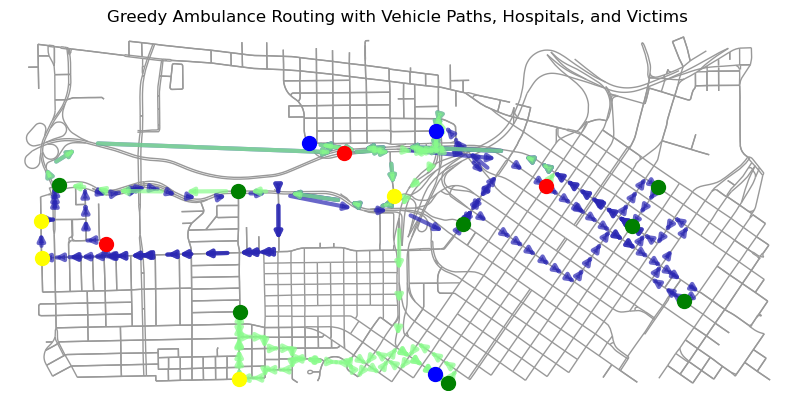

In [3]:
import random

def generate_random_color():
    """Generates a random color in hex format."""
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return f"#{r:02x}{g:02x}{b:02x}"

# Define the plotting function with updated color logic
def plot_road_network_with_routes(G_small, vehicles, vehicle_matrices, victims, hospitals):
    """
    Plots the road network along with vehicle routes, hospitals, and victims.
    
    Parameters:
    - G_small: NetworkX graph representing the road network
    - vehicles: List of vehicles in the simulation
    - vehicle_matrices: Dictionary containing matrices for vehicles with keys as vehicle types
    - victims: List of victims to be helped
    - hospitals: List of hospitals for vehicle drop-off
    """
    # Extract the positions of the nodes using osmnx
    node_gdf, edge_gdf = ox.graph_to_gdfs(G_small)  # Get GeoDataFrames for nodes and edges
    pos = {node: (node_gdf.loc[node, 'x'], node_gdf.loc[node, 'y']) for node in G_small.nodes}

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the road network (base layer)
    ox.plot_graph(G_small, ax=ax, node_size=0, bgcolor='lightgray', show=False)

    # Plot the route of each vehicle with random colors
    for vehicle in vehicles:
        # Assign a random color to the vehicle
        color = generate_random_color()
        
        # Get the vehicle's route (you can replace this with the vehicle's specific route data)
        route_nodes = vehicle.route
        
        # Get the shortest path from vehicle_matrices (assuming it's based on type and locations)
        vehicle_type = vehicle.type  # Adjust according to your vehicle type structure
        route_edges = [(route_nodes[i], route_nodes[i + 1]) for i in range(len(route_nodes) - 1)]
        
        # Loop over the edges and plot the route
        for edge in route_edges:
            # Fetch the shortest path from the vehicle's matrix
            location1, location2 = edge
            shortest_path = vehicle_matrices[vehicle_type][location1][location2]['path']

            # Plot the shortest path for this edge using the assigned color
            nx.draw_networkx_edges(G_small, ax=ax, edgelist=[(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path)-1)],
                                   edge_color=color, width=3, alpha=0.7, label=f"Vehicle {vehicle.index} Route", pos=pos)

    # Plot the hospitals (blue) and victims with specific colors based on their status
    for hospital in hospitals:
        hospital_node = hospital.location
        ax.scatter(pos[hospital_node][0], pos[hospital_node][1], color='blue', s=100, label="Hospital")

    for victim in victims:
        victim_node = victim.location
        # Color victims based on their type
        if victim.rating == 'U':  # Unknown victim
            victim_color = 'yellow'
        elif victim.rating == 'G':  # Green victim
            victim_color = 'green'
        else:  # Red victim
            victim_color = 'red'
        
        ax.scatter(pos[victim_node][0], pos[victim_node][1], color=victim_color, s=100, label=f"Victim ({victim.rating})")

    # Display the plot with title
    plt.title("Greedy Ambulance Routing with Vehicle Paths, Hospitals, and Victims")
    plt.show()

# Example usage of the function:
plot_road_network_with_routes(G_small, vehicles, vehicle_matrices, victims, hospitals)


@10:41 PM on Jan 7 -
#allocate helicopter to victims that weren't reachable (bc of too high risk damage) --- if the victim isn't reached at the end; js put assign them to the helicopter and use euclidean dist for helicopters
#instead of doing total_risk, do avg_risk (for comparing the diff models) 

oh also for plotting, use diff colors

how would u check the competitive ratio or some shit  
- for the other algs make a diff algo for checking over skipping green victims in some cases (similar to that study) 